# Tutorial 2: Viga biempotrada con carga de gravedad

En este primer tutorial resolveremos el problema de una **viga rectangular biempotrada** sometida a su propio peso (gravedad). Utilizaremos elementos triangulares lineales (CST) en régimen de esfuerzo plano. El objetivo es doble:

* Aprender a utilizar las clases de **femppp** para definir la geometría, las condiciones de borde, las cargas y resolver el problema.
* Validar la solución numérica comparándola con la **solución analítica** de la teoría de vigas de Euler‑Bernoulli y estudiar la **convergencia** del elemento al refinar la malla.



## 1. Descripción del problema físico

Consideramos una viga recta de longitud $L = 10.0\,\text{m}$, altura (canto) $H = 1.0\,\text{m}$ y espesor (fuera del plano) $t = 0.1\,\text{m}$. El material es acero con módulo de Young $E = 200\,\text{GPa}$, coeficiente de Poisson $\nu = 0.3$ y densidad $\rho = 7800\,\text{kg/m}^3$.

La viga está **empotrada** en ambos extremos ($x = 0$ y $x = L$), es decir, todos los desplazamientos ($u_x, u_y$) son nulos en esas caras. Sobre toda la viga actúa la **gravedad** en dirección vertical negativa, con aceleración $g = 9.81\,\text{m/s}^2$. Esto se traduce en una fuerza por unidad de volumen:

$$
b_x = 0, \qquad b_y = -\rho g = -76518\,\text{N/m}^3
$$

## 2. Solución analítica (teoría de vigas)

Para una viga biempotrada de sección constante, con carga uniformemente distribuida $q$ (en N/m a lo largo de la viga), la **deflexión máxima** (en el centro) viene dada por:

$$
w_{\text{max}} = -\frac{q L^4}{384\,E I}
$$

El signo negativo indica que la deflexión es hacia abajo. La carga por unidad de longitud se obtiene del peso propio:

$$
q = \rho \, g \, H \, t
$$

El momento de inercia de la sección rectangular es:

$$
I = \frac{t H^3}{12}
$$

La **tensión normal máxima** (en las fibras extremas de los empotramientos) vale:

$$
\sigma_{xx,\text{max}} = \frac{M_{\text{max}}\,c}{I}, \qquad 
M_{\text{max}} = \frac{q L^2}{12}, \quad c = \frac{H}{2}
$$

Sustituyendo:

$$
\sigma_{xx,\text{max}} = \frac{q L^2}{2\,t H^2}
$$

Con los valores numéricos dados, se obtienen:

$$
\begin{aligned}
q &= 7800 \times 9.81 \times 1.0 \times 0.1 = 7651.8\,\text{N/m} \\
I &= 0.1 \times 1.0^3 / 12 = 8.3333\times 10^{-3}\,\text{m}^4 \\
w_{\text{max}} &= -\frac{7651.8 \times 10^4}{384 \times 200\times 10^9 \times 8.3333\times 10^{-3}} = -1.196\times 10^{-4}\,\text{m} = -119.6\,\mu\text{m} \\
\sigma_{xx,\text{max}} &= \frac{7651.8 \times 10^2}{2 \times 0.1 \times 1.0^2} = 3.826\times 10^6\,\text{Pa} = 3.83\,\text{MPa}
\end{aligned}
$$

Estos valores serán nuestra referencia para la validación.

## 3. Implementación paso a paso con `femppp`

A continuación se muestra el código completo, dividido en secciones lógicas. Cada parte está comentada de forma breve para facilitar su comprensión.

### 3.1 Importación de módulos y definición de parámetros

Comenzamos importando `numpy`, `matplotlib` y las clases de `femppp`. Definimos todas las constantes físicas y geométricas.


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from femppp import *   # Clases: FEMProblem, TriangularElement, Tessellation

# Parámetros físicos
L = 10.0          # longitud [m]
H = 1.0           # altura [m]
t = 0.1           # espesor [m]
E = 200e9         # módulo de Young [Pa]
nu = 0.3          # coeficiente de Poisson
rho = 7800.0      # densidad [kg/m^3]
g = 9.81          # gravedad [m/s^2]

# Carga de volumen (gravedad)
bx = 0.0
by = -rho * g     # [N/m^3]


### 3.2 Generación de la malla

Creamos una malla estructurada rectangular (grid) que luego triangulamos mediante la clase `Tessellation` (que internamente utiliza `scipy.spatial.Delaunay`). Elegimos una resolución moderada.

Número de nodos: 600
Número de elementos: 1092


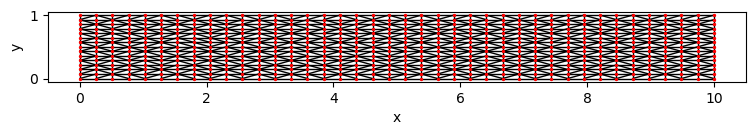

In [7]:
# ------------------------------------------------------------
# Malla estructurada de triángulos
# ------------------------------------------------------------
nx = 40          # divisiones en dirección x
ny = 15          # divisiones en dirección y

x = np.linspace(0, L, nx)
y = np.linspace(0, H, ny)
X, Y = np.meshgrid(x, y)
points = np.column_stack((X.ravel(), Y.ravel()))

tess = Tessellation(points)
simplices = tess.simplices  # conectividades de los triángulos

print(f"Número de nodos: {points.shape[0]}")
print(f"Número de elementos: {len(simplices)}")

# Visualización de la malla (opcional)
tess.plot(show_node_ids=False, show_element_ids=False, node_size=2, figure_size=(9,6))


### 3.3 Creación de los elementos finitos

Recorremos la lista de triángulos y creamos un objeto `TriangularElement` para cada uno, pasando las coordenadas nodales y las propiedades del material.


In [8]:
# ------------------------------------------------------------
# Creación de elementos CST
# ------------------------------------------------------------
elements = []
for tri_nodes in simplices:
    elem = TriangularElement(
        node_ids=tri_nodes,
        nodes=points,
        E=E,
        nu=nu,
        thickness=t,
        element_type="CST"
    )
    elements.append(elem)


### 3.4 Ensamblaje del problema y condiciones de contorno

Construimos el objeto `FEMProblem`, que ensamblará la matriz de rigidez global y el vector de fuerzas. Luego aplicamos:

* **Empotramiento en ambos extremos**: fijamos $u_x = u_y = 0$ en todos los nodos con $x \approx 0$ y $x \approx L$.
* **Carga de cuerpo**: la gravedad se aplica mediante `apply_body_force`.


In [9]:
# ------------------------------------------------------------
# Ensamblaje del problema
# ------------------------------------------------------------
problem = FEMProblem(elements)
problem.assemble_stiffness()

# Condiciones de borde: empotramiento en x=0 y x=L
tol = 1e-6
left_nodes  = np.where(np.abs(points[:, 0] - 0.0) < tol)[0]
right_nodes = np.where(np.abs(points[:, 0] - L)   < tol)[0]

# Valores nulos para todos los grados de libertad
dirichlet_left  = np.zeros((len(left_nodes), 2))
dirichlet_right = np.zeros((len(right_nodes), 2))

problem.apply_dirichlet_bcs(nodes=right_nodes, values=dirichlet_right)
problem.apply_dirichlet_bcs(nodes=left_nodes,  values=dirichlet_left)

# Carga de cuerpo: gravedad
problem.apply_body_force(bx, by)


### 3.5 Solución del sistema

Resolvemos el sistema lineal mediante un solver directo (`spsolve`) y calculamos las tensiones en los elementos.


In [10]:
# ------------------------------------------------------------
# Solución
# ------------------------------------------------------------
problem.solve(method='direct')      # también puede ser 'cg', 'gmres', etc.
problem.compute_element_stresses()  # calcula tensiones en cada elemento


### 3.6 Visualización de resultados

Podemos dibujar el contorno deformado (amplificado) y la distribución de la tensión de von Mises.


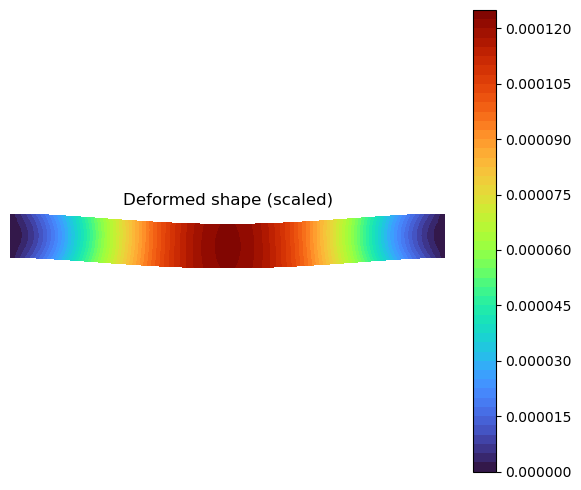

In [12]:
# Contorno deformado (escala 2000x para hacer visible la deformación)
plot_deformed_contour(
    tess.points,
    tess.simplices,
    problem.ux,
    problem.uy,
    scale=2000
)

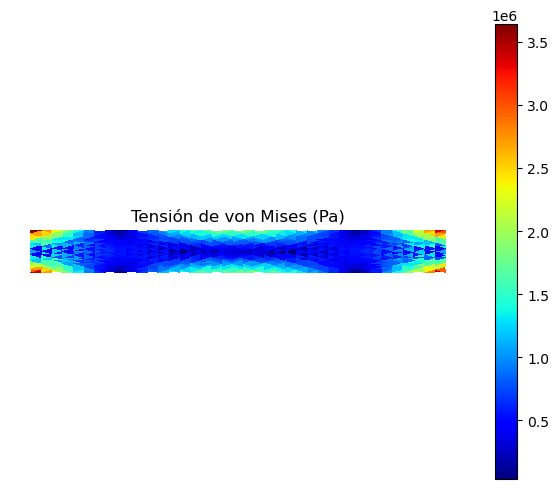

In [13]:
# Tensión de von Mises por elemento
problem.plot_elemental_variable(
    tess.points,
    tess.simplices,
    problem.sigma_vm,
    title="Tensión de von Mises (Pa)"
)


### 3.7 Extracción de resultados numéricos y comparación con la solución analítica

Obtenemos la deflexión máxima (el valor mínimo de `uy`, que corresponde al centro de la viga) y la tensión normal máxima aproximada en los extremos.


In [14]:
# ------------------------------------------------------------
# Resultados analíticos (ya calculados)
# ------------------------------------------------------------
q = rho * g * H * t
I = t * H**3 / 12
w_max_analytical = -q * L**4 / (384 * E * I)
sigma_max_analytical = q * L**2 / (2 * t * H**2)

print("\n--- Solución analítica (Euler-Bernoulli) ---")
print(f"Deflexión máxima en el centro: {w_max_analytical*1e6:.2f} µm")
print(f"Tensión normal máxima en extremos: {sigma_max_analytical/1e6:.3f} MPa")

# ------------------------------------------------------------
# Resultados FEM
# ------------------------------------------------------------
# Deflexión máxima = mínimo de uy (todos los valores son negativos)
deflection_fem = np.min(problem.uy)

# Para la tensión, tomamos elementos cercanos a los extremos (x≈0 o x≈L) y a las fibras superior/inferior
centroids = np.array([np.mean(points[elem.node_ids], axis=0) for elem in elements])
stress_xx = problem.sigma_xx

mask_left_top  = (centroids[:,0] < 0.1*L) & (centroids[:,1] > 0.9*H)
mask_left_bot  = (centroids[:,0] < 0.1*L) & (centroids[:,1] < 0.1*H)
mask_right_top = (centroids[:,0] > 0.9*L) & (centroids[:,1] > 0.9*H)
mask_right_bot = (centroids[:,0] > 0.9*L) & (centroids[:,1] < 0.1*H)

stress_at_ends = np.concatenate([
    stress_xx[mask_left_top],
    stress_xx[mask_left_bot],
    stress_xx[mask_right_top],
    stress_xx[mask_right_bot]
])

fem_sigma_max = np.max(np.abs(stress_at_ends))

print("\n--- Solución FEM (CST) ---")
print(f"Deflexión vertical máxima: {deflection_fem*1e6:.2f} µm")
print(f"Error relativo en deflexión: {abs(deflection_fem - w_max_analytical)/abs(w_max_analytical)*100:.2f}%")
print(f"Tensión normal máxima (aprox.) en extremos: {fem_sigma_max/1e6:.3f} MPa")
print(f"Error relativo en tensión: {abs(fem_sigma_max - sigma_max_analytical)/sigma_max_analytical*100:.2f}%")



--- Solución analítica (Euler-Bernoulli) ---
Deflexión máxima en el centro: -119.56 µm
Tensión normal máxima en extremos: 3.826 MPa

--- Solución FEM (CST) ---
Deflexión vertical máxima: -123.25 µm
Error relativo en deflexión: 3.09%
Tensión normal máxima (aprox.) en extremos: 3.714 MPa
Error relativo en tensión: 2.93%


## 4. Estudio de convergencia

Para observar cómo se comporta el elemento CST al refinar la malla, repetimos el análisis con varias discretizaciones y registramos el error en la deflexión. A continuación se muestra el código que automatiza este estudio.


In [17]:
# ------------------------------------------------------------
# Estudio de convergencia
# ------------------------------------------------------------
refinements = [
    (10, 4),
    (20, 8),
    (30, 12),
]

results = []

for nx, ny in refinements:
    print(f"\n--- Malla: nx={nx}, ny={ny} ---")
    
    # Generar puntos
    x = np.linspace(0.0, L, nx)
    y = np.linspace(0.0, H, ny)
    X, Y = np.meshgrid(x, y)
    points = np.column_stack((X.ravel(), Y.ravel()))
    tess = Tessellation(points)
    
    # Crear elementos
    elements = []
    for tri in tess.simplices:
        elements.append(TriangularElement(
            node_ids=tri, nodes=tess.points,
            E=E, nu=nu, thickness=t, element_type="CST"
        ))
    
    # Ensamblar y resolver
    problem = FEMProblem(elements)
    problem.assemble_stiffness()
    
    # Condiciones de borde
    left_nodes  = np.where(np.isclose(tess.points[:,0], 0.0))[0]
    right_nodes = np.where(np.isclose(tess.points[:,0], L))[0]
    problem.apply_dirichlet_bcs(left_nodes,  np.zeros((len(left_nodes),2)))
    problem.apply_dirichlet_bcs(right_nodes, np.zeros((len(right_nodes),2)))
    
    problem.apply_body_force(bx, by)
    problem.solve(method='direct')
    
    # Deflexión máxima
    deflection_fem = np.min(problem.uy)
    error = abs((deflection_fem - w_max_analytical) / w_max_analytical) * 100
    
    results.append({
        'nx': nx, 'ny': ny,
        'n_nodes': tess.n_nodes,
        'n_elements': tess.n_elements,
        'deflection (µm)': deflection_fem * 1e6,
        'error (%)': error
    })
    
    print(f"  Nodos: {tess.n_nodes}, Elementos: {tess.n_elements}")
    print(f"  Deflexión FEM: {deflection_fem*1e6:.2f} µm, Error: {error:.3f}%")

# Mostrar tabla
import pandas as pd
df = pd.DataFrame(results)
print("\nTabla de convergencia:")
df



--- Malla: nx=10, ny=4 ---
  Nodos: 40, Elementos: 93
  Deflexión FEM: -54.53 µm, Error: 54.395%

--- Malla: nx=20, ny=8 ---
  Nodos: 160, Elementos: 425
  Deflexión FEM: -99.58 µm, Error: 16.713%

--- Malla: nx=30, ny=12 ---
  Nodos: 360, Elementos: 997
  Deflexión FEM: -115.96 µm, Error: 3.010%

Tabla de convergencia:


,nx,ny,n_nodes,n_elements,deflection (µm),error (%)
0,10,4,40,93,-54.525464,54.394656
1,20,8,160,425,-99.576911,16.713423
2,30,12,360,997,-115.960236,3.010336



### 4.1 Gráfico de convergencia

Representamos el error relativo frente al número de nodos en escala log‑log. La pendiente negativa indica la tasa de convergencia del elemento.


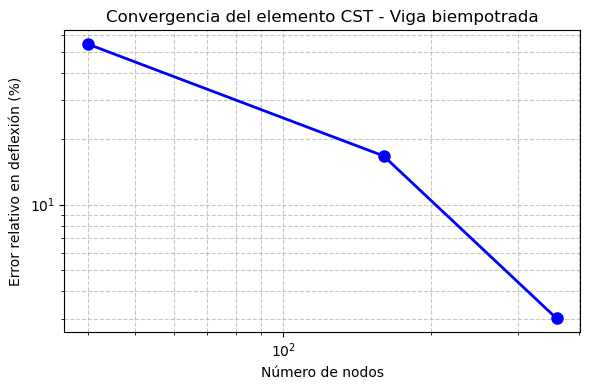

In [18]:
plt.figure(figsize=(6,4))
plt.loglog(df['n_nodes'], df['error (%)'], 'bo-', linewidth=2, markersize=8)
plt.xlabel('Número de nodos')
plt.ylabel('Error relativo en deflexión (%)')
plt.title('Convergencia del elemento CST - Viga biempotrada')
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



## 5. Distribución de tensiones en el empotramiento

Finalmente, comparamos la distribución de $\sigma_{xx}$ a lo largo de la altura en la sección del empotramiento (por ejemplo, en $x \approx 0$) con la solución analítica lineal. Utilizamos la malla más fina de la lista y promediamos los valores de los elementos en cada nodo (técnica de promedio nodal).


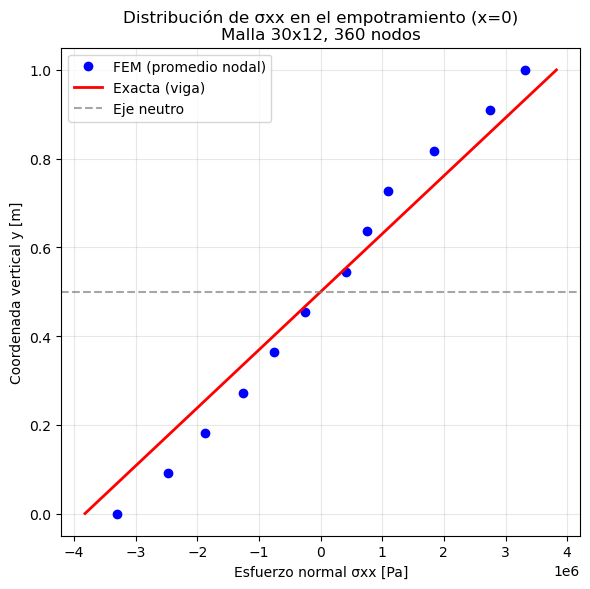

In [20]:
# ------------------------------------------------------------
# Usar la malla más fina (última de refinements)
# ------------------------------------------------------------
nx_fine, ny_fine = refinements[-1]
x_fine = np.linspace(0, L, nx_fine)
y_fine = np.linspace(0, H, ny_fine)
X_fine, Y_fine = np.meshgrid(x_fine, y_fine)
points_fine = np.column_stack((X_fine.ravel(), Y_fine.ravel()))
tess_fine = Tessellation(points_fine)

# Crear elementos
elements_fine = []
for tri in tess_fine.simplices:
    elements_fine.append(TriangularElement(
        node_ids=tri, nodes=tess_fine.points,
        E=E, nu=nu, thickness=t, element_type="CST"
    ))

# Ensamblar y resolver
problem_fine = FEMProblem(elements_fine)
problem_fine.assemble_stiffness()

# Condiciones de borde
left_nodes_fine  = np.where(np.isclose(tess_fine.points[:,0], 0.0))[0]
right_nodes_fine = np.where(np.isclose(tess_fine.points[:,0], L))[0]
problem_fine.apply_dirichlet_bcs(left_nodes_fine,  np.zeros((len(left_nodes_fine),2)))
problem_fine.apply_dirichlet_bcs(right_nodes_fine, np.zeros((len(right_nodes_fine),2)))
problem_fine.apply_body_force(bx, by)
problem_fine.solve(method='direct')
problem_fine.compute_element_stresses()

# --- Promedio nodal de σxx ---
sigma_all = problem_fine.element_stress   # (n_elem, 3)
n_nodes_fine = tess_fine.n_nodes
sigma_xx_nodal = np.zeros(n_nodes_fine)
count_nodal = np.zeros(n_nodes_fine, dtype=int)

for elem, stress in zip(elements_fine, sigma_all):
    for node_id in elem.node_ids:
        sigma_xx_nodal[node_id] += stress[0]   # σxx
        count_nodal[node_id] += 1

count_nodal[count_nodal == 0] = 1
sigma_xx_nodal /= count_nodal

# Extraer nodos en el borde izquierdo (empotramiento)
left_mask = np.isclose(tess_fine.points[:,0], 0.0)
left_indices = np.where(left_mask)[0]
y_left = tess_fine.points[left_indices, 1]
sigma_left = sigma_xx_nodal[left_indices]

# Ordenar por coordenada y
sort_idx = np.argsort(y_left)
y_left_sorted = y_left[sort_idx]
sigma_left_sorted = sigma_left[sort_idx]

# Solución exacta en el empotramiento (momento flector M = qL²/12)
M_emp = q * L**2 / 12
y_exact = np.linspace(0, H, 100)
sigma_exact = M_emp * (y_exact - H/2) / I

# Graficar
plt.figure(figsize=(6,6))
plt.plot(sigma_left_sorted, y_left_sorted, 'bo', markersize=6, label='FEM (promedio nodal)')
plt.plot(sigma_exact, y_exact, 'r-', linewidth=2, label='Exacta (viga)')
plt.axhline(y=H/2, color='gray', linestyle='--', alpha=0.7, label='Eje neutro')
plt.xlabel('Esfuerzo normal σxx [Pa]')
plt.ylabel('Coordenada vertical y [m]')
plt.title(f'Distribución de σxx en el empotramiento (x=0)\nMalla {nx_fine}x{ny_fine}, {n_nodes_fine} nodos')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
